# Simulation Work

## 1. Import Libraries

In [5]:
from distutils.command.config import config
import pandas as pd
import geopandas as gp
import plotly.express as px
import numpy as np
import math
import random
from scipy import optimize
import itertools
import warnings
warnings.filterwarnings('ignore')

## 2. Define simulation variables

### Campaign names

In [ ]:
SIM_TYPE_RANDOMN = 'Random-N'
SIM_TYPE_TOPN = 'Top-N'
SIM_TYPE_BOTTOMN = 'Bottom-N'
SIM_TYPE_CUSTOM = 'Custom'
SIM_TYPE_SUSTAINABLE = 'Sustainable-N'
SIM_TYPE_CAPACITY = "Capacity-N"

### Other params

In [ ]:
CHOICE_UTILITY = 5
ALL_COUNTRIES = "All Countries"

district_code_map = {1: "Bozen", 2: "Burggrafenamt", 3: "Eisacktal", 4: "Pustertal", 5: "Salten-Schlern", 6: "Uberetsch-Unterland", 7: "Vinschgau", 8: "Wipptal"}
district_code_map_reverse = {"Bozen": 1, "Burggrafenamt": 2, "Eisacktal": 3, "Pustertal": 4, "Salten-Schlern": 5, "Uberetsch-Unterland": 6, "Vinschgau": 7, "Wipptal": 8}

DECAY_RATE = 1.2

similarities = pd.read_csv('../data/similarities_indexed.csv', index_col=0)
dataForPresences = pd.read_csv('../data/presences_simulation.csv')

## 3. Define functions

In [ ]:
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [ ]:
def getK(utilities, user_choice, conv_rate):

    def func(x):
        
        total = 0
        
        for key in utilities:
            if not key == user_choice:
                total = total + math.exp(utilities[key]*x)
            
        return total - (math.exp(5)/(1 - conv_rate/100) - math.exp(5))

    if conv_rate == 0:
        return float('-inf')
    
    sol = optimize.root_scalar(func, bracket=[0,10.], method='brentq')
    x = sol.root

    return x

In [ ]:
def getUtilities(advertisement, userChoice, decay_rate, conv_rate = -1):

    utilities = {userChoice: CHOICE_UTILITY}

    for index, d in enumerate(advertisement):
        if not d in utilities:
            utility = similarities[str(userChoice)].loc[d]*CHOICE_UTILITY/(decay_rate**index) 
            utilities[d] = utility 
        
    if not conv_rate == -1:
        k = getK(utilities, userChoice, conv_rate)
        for key in utilities:
            if not key == userChoice:
                utilities[key] = utilities[key] * k
        
    return utilities

In [ ]:
def getProbabilities(utilities):
    
    elSum = 0
    probabilities = {}
    
    for uKey in utilities:
        elSum = elSum + math.exp(utilities[uKey])
    
    for uKey in utilities:
        probabilities[uKey] = math.exp(utilities[uKey])/elSum
        
    return probabilities

In [ ]:
def getSustainableForDistrict(district, k, dataframe, column):
    similaritiesToDistrict = similarities[str(district)].sort_values(ascending=False)
    sustainableItems = dataframe.sort_values(by=column, ascending=True)['district_c'].head(4).tolist()

    sustainableAd = []
    for index, row in similaritiesToDistrict.items():
        if index != district:
            if index in sustainableItems:
                sustainableAd.append(index)
            if len(sustainableAd) == k:
                return sustainableAd
    return sustainableAd

In [ ]:
def getSusCapacityForDistrict(district, k, dataframe, column):
    similaritiesToDistrict = similarities[str(district)].sort_values(ascending=False)
    sustainableItems = dataframe.sort_values(by="Rank", ascending=False)['district_c'].head(4).tolist()

    sustainableAd = []
    for index, row in similaritiesToDistrict.items():
        if index != district:
            if index in sustainableItems:
                sustainableAd.append(index)
            if len(sustainableAd) == k:
                return sustainableAd
    return sustainableAd

In [ ]:
def getMeanAndStandardDeviation(year, month, district_c):
    filteredDf = dataForPresences[(dataForPresences["Year"] == year) & (dataForPresences["Month"] == month) & (dataForPresences["district_c"] == district_c ) ]
    filteredDf["AverageStay"] = filteredDf["Present"] / filteredDf["Arrivals"]
    filteredDf.replace([np.inf, -np.inf], 0, inplace=True)
    return [filteredDf["AverageStay"].mean(), filteredDf["AverageStay"].std()]

## 4. Run simulation functions

In [ ]:
districtsRankedCapacity = pd.read_csv("../data/districts_ranked.csv")

In [ ]:
districts = gp.read_file('../data/geo_district_df.shp')

In [ ]:
districtsRankedCapacity =  districtsRankedCapacity.merge(districts[["district_c", "beds"]], on='district_c',
                                     how="left", suffixes=('', '_y'))

In [ ]:
districtsRankedCapacity["freeBeds"] = districtsRankedCapacity["beds"] - districtsRankedCapacity["Present"] / 365 

In [ ]:
districtsRankedCapacity['Rank'] = districtsRankedCapacity.groupby('Year')['freeBeds'].rank(ascending=True)

In [ ]:
districtsRankedCapacity = districtsRankedCapacity.round(2)

In [ ]:
districtsRankedCapacity.to_csv("../data/districts_ranked_capacity.csv")

In [ ]:
def run_capacity(year, conv_rate, k, seen_rate, nationality_filter, decay_rate):
    
    adDictionary = {}
    utilitiesDictionary = {}
    probabilitiesDictionary = {}
    changedOpinionCount = 0
    consumedFromAdvertisementCount = 0


    if nationality_filter == ALL_COUNTRIES:

        arrivalCounts = pd.read_csv("../data/districts_ranked_capacity.csv")
        column = 'Arrivals'
    
    else:

        arrivalCounts = pd.read_csv("../data/yearly_arrivals_by_nat_and_dist.csv")
        column = nationality_filter

    ac = arrivalCounts[arrivalCounts['Year'] == year]

    for i in range(1, 9):
        adDictionary[i] = getSusCapacityForDistrict(i, k, ac, column)
        if not conv_rate == -1:
            utilitiesDictionary[i] = getUtilities(adDictionary[i], i, decay_rate, conv_rate)
        else:
            utilitiesDictionary[i] = getUtilities(adDictionary[i], i, decay_rate)

        probabilitiesDictionary[i] = getProbabilities(utilitiesDictionary[i])
        
    print(probabilitiesDictionary)

    # setup stuff
    arrivals = pd.read_csv('../data/nationality_long.csv')
    arrivals = arrivals[arrivals['Year'] == year]

    arrivalsDf = arrivals

    # construct a new dataframe
    df = pd.DataFrame(columns=['Year', 'Month', 'Season', 'district_c', 'District', 'Arrivals', 'Present'])

    filter = 'Arrivals' if nationality_filter == ALL_COUNTRIES else nationality_filter

    nonArrivals = arrivalsDf.copy()
    arrivalsDf['Arrivals'] = arrivalsDf[filter].multiply(seen_rate/100).round()

    nonArrivals['Arrivals'] = nonArrivals['Arrivals'] - arrivalsDf['Arrivals']
    
    nonArrivals['Ratio'] = arrivalsDf[filter].multiply((100-seen_rate)/100).round() / arrivalsDf['Arrivals']
    
    nonArrivals['Present'] = nonArrivals['Ratio'] * arrivalsDf['Present']


    for i, row in arrivalsDf.iterrows():

        probabilities = probabilitiesDictionary[row['district_c']]

        elements = list(probabilities.keys())
        
        choices = random.choices(elements, weights=list(probabilities.values()), k=int(row['Arrivals']))
        
        changedOpinion = sum(map(lambda c : c != row['district_c'], choices))
        changedOpinionCount = changedOpinionCount + changedOpinion
        
        consumedFromAdvertisement = sum(map(lambda c : c in elements, choices))
        consumedFromAdvertisementCount = consumedFromAdvertisementCount + consumedFromAdvertisement
        
        start = [row['Year'], row['Month'], row['Season']]
    
        s_row = pd.Series(start + [nonArrivals.loc[i, 'district_c']] + [district_code_map[nonArrivals.loc[i, 'district_c']]] + [nonArrivals.loc[i, "Arrivals"]] + [nonArrivals.loc[i, "Present"]], index=df.columns)
        df = df.append(s_row,ignore_index=True)
        
        results = getMeanAndStandardDeviation(row['Year'], row['Month'], row['district_c'])
        mean = results[0]
        std = results[1]
        
        simulatedPresences = np.random.normal(mean, std, int(row['Arrivals']))

        for dist in range(1, 9):

            arrivalsToDistrict = choices.count(dist)
            
            presenceArray = simulatedPresences[:arrivalsToDistrict]
            simulatedPresences = simulatedPresences[arrivalsToDistrict:]
            
            sumOfPresences = np.sum(presenceArray)
            
            s_row = pd.Series(start + [dist] + [district_code_map[dist]] + [arrivalsToDistrict] + [sumOfPresences], index=df.columns)
            df = df.append(s_row,ignore_index=True)

    simulatedResults = df.groupby(by=['Year', 'Month', 'Season', 'district_c', 'District']).agg({'Arrivals': 'sum', 'Present': 'sum'}).reset_index()

    arrivals2 = pd.read_csv('../data/nationality_trends.csv')
    arrivals2 = arrivals2[arrivals2['Year'] == year]
    arrivals2 = arrivals2.groupby(by=['Year', 'Month', 'Season', 'district_c']).sum().reset_index()

    arrivals2 = arrivals2.merge(simulatedResults, how='inner', on=["Year", "Month", "district_c"], suffixes=("", "_sim"))
    arrivals2 = arrivals2.drop(['Season_sim'], axis = 1)
    arrivals2['Diff'] = arrivals2['Arrivals_sim'] - arrivals2['Arrivals']
    
    arrivals2['sim_present'] = arrivals2['Present_sim']
    
    return [arrivals2, changedOpinionCount, consumedFromAdvertisementCount]

In [ ]:
def run_sustainable(year, conv_rate, k, seen_rate, nationality_filter, decay_rate):
    
    adDictionary = {}
    utilitiesDictionary = {}
    probabilitiesDictionary = {}
    changedOpinionCount = 0
    consumedFromAdvertisementCount = 0


    if nationality_filter == ALL_COUNTRIES:

        arrivalCounts = pd.read_csv("../data/districts_ranked.csv")
        column = 'Arrivals'
    
    else:

        arrivalCounts = pd.read_csv("../data/yearly_arrivals_by_nat_and_dist.csv")
        column = nationality_filter

    ac = arrivalCounts[arrivalCounts['Year'] == year]

    for i in range(1, 9):
        adDictionary[i] = getSustainableForDistrict(i, k, ac, column)
        if not conv_rate == -1:
            utilitiesDictionary[i] = getUtilities(adDictionary[i], i, decay_rate, conv_rate)
        else:
            utilitiesDictionary[i] = getUtilities(adDictionary[i], i, decay_rate)

        probabilitiesDictionary[i] = getProbabilities(utilitiesDictionary[i])
        
    print(probabilitiesDictionary)

    # setup stuff
    arrivals = pd.read_csv('../data/nationality_long.csv')
    arrivals = arrivals[arrivals['Year'] == year]

    arrivalsDf = arrivals

    # construct a new dataframe
    df = pd.DataFrame(columns=['Year', 'Month', 'Season', 'district_c', 'District', 'Arrivals', 'Present'])

    filter = 'Arrivals' if nationality_filter == ALL_COUNTRIES else nationality_filter

    nonArrivals = arrivalsDf.copy()
    arrivalsDf['Arrivals'] = arrivalsDf[filter].multiply(seen_rate/100).round()

    nonArrivals['Arrivals'] = nonArrivals['Arrivals'] - arrivalsDf['Arrivals']
    
    nonArrivals['Ratio'] = arrivalsDf[filter].multiply((100-seen_rate)/100).round() / arrivalsDf['Arrivals']
    
    nonArrivals['Present'] = nonArrivals['Ratio'] * arrivalsDf['Present']


    for i, row in arrivalsDf.iterrows():

        probabilities = probabilitiesDictionary[row['district_c']]

        elements = list(probabilities.keys())
        
        choices = random.choices(elements, weights=list(probabilities.values()), k=int(row['Arrivals']))
        
        changedOpinion = sum(map(lambda c : c != row['district_c'], choices))
        changedOpinionCount = changedOpinionCount + changedOpinion
        
        start = [row['Year'], row['Month'], row['Season']]
    
        s_row = pd.Series(start + [nonArrivals.loc[i, 'district_c']] + [district_code_map[nonArrivals.loc[i, 'district_c']]] + [nonArrivals.loc[i, "Arrivals"]] + [nonArrivals.loc[i, "Present"]], index=df.columns)
        df = df.append(s_row,ignore_index=True)
        
        results = getMeanAndStandardDeviation(row['Year'], row['Month'], row['district_c'])
        mean = results[0]
        std = results[1]
        
        simulatedPresences = np.random.normal(mean, std, int(row['Arrivals']))

        for dist in range(1, 9):

            arrivalsToDistrict = choices.count(dist)
            
            presenceArray = simulatedPresences[:arrivalsToDistrict]
            simulatedPresences = simulatedPresences[arrivalsToDistrict:]
            
            sumOfPresences = np.sum(presenceArray)
            
            s_row = pd.Series(start + [dist] + [district_code_map[dist]] + [arrivalsToDistrict] + [sumOfPresences], index=df.columns)
            df = df.append(s_row,ignore_index=True)

    simulatedResults = df.groupby(by=['Year', 'Month', 'Season', 'district_c', 'District']).agg({'Arrivals': 'sum', 'Present': 'sum'}).reset_index()
    
    arrivals2 = pd.read_csv('../data/nationality_trends.csv')
    arrivals2 = arrivals2[arrivals2['Year'] == year]
    arrivals2 = arrivals2.groupby(by=['Year', 'Month', 'Season', 'district_c']).sum().reset_index()

    arrivals2 = arrivals2.merge(simulatedResults, how='inner', on=["Year", "Month", "district_c"], suffixes=("", "_sim"))
    arrivals2 = arrivals2.drop(['Season_sim'], axis = 1)
    arrivals2['Diff'] = arrivals2['Arrivals_sim'] - arrivals2['Arrivals']
    
    arrivals2['sim_present'] = arrivals2['Present_sim']
    
    return [arrivals2, changedOpinionCount, consumedFromAdvertisementCount]

In [ ]:
def run_random(year, n, conv_rate, seen_rate, nationality_filter, decay_rate):

    advertisementMap = {}
    utilityMap = {}
    probabilityMap = {}
    
    changedOpinionCount = 0
    consumedFromAdvertisementCount = 0

    items = list(range(1, 9))
    
    for i in items: 
        advertisementMap[i] = {}
        elements = list(range(1, 9))
        elements.remove(i)
        for index, adCombination in enumerate(itertools.combinations(elements, n)):
            ad = list(adCombination)
            advertisementMap[i][index] = ad
        
    for i in range(1, 9):
        utilityMap[i] = {}
        probabilityMap[i] = {}
        for key in advertisementMap[i].keys():
            if not conv_rate == -1:
                utilities = getUtilities(advertisementMap[i][key], i, decay_rate, conv_rate)
            else:
                utilities = getUtilities(advertisementMap[i][key], i, decay_rate)
            utilityMap[i][key] = utilities
            probabilities = getProbabilities(utilities)
            probabilityMap[i][key] = probabilities 
        

    # setup stuff
    arrivals = pd.read_csv('../data/nationality_long.csv')
    arrivals = arrivals[arrivals['Year'] == year]

    arrivalsDf = arrivals

    
    # construct a new dataframe
    df = pd.DataFrame(columns=['Year', 'Month', 'Season', 'district_c', 'District', 'Arrivals', 'Present'])

    filter = 'Arrivals' if nationality_filter == ALL_COUNTRIES else nationality_filter

    nonArrivals = arrivalsDf.copy()
    
    arrivalsDf['Arrivals'] = arrivalsDf[filter].multiply(seen_rate/100).round()

    nonArrivals['Arrivals'] = nonArrivals['Arrivals'] - arrivalsDf['Arrivals']

    
    nonArrivals['Ratio'] = arrivalsDf[filter].multiply((100-seen_rate)/100).round() / arrivalsDf['Arrivals']
    
    nonArrivals['Present'] = nonArrivals['Ratio'] * arrivalsDf['Present']



    for i, row in arrivalsDf.iterrows():

        choices = []

        adNumberChoices = random.choices(list(utilityMap[row['district_c']].keys()), k = int(row['Arrivals']) )
        
        for x in range(int(row['Arrivals'])):

            adNumber = adNumberChoices[x]#random.choice(list(utilityMap[row['district_c']].keys()))
            probabilities = probabilityMap[row['district_c']][adNumber]
            elements = list(probabilities.keys())

            choice = random.choices(elements, weights=list(probabilities.values()), k=1)

            choices.append(choice[0])
        
        start = [row['Year'], row['Month'], row['Season']]

        a1 = [nonArrivals.loc[i, 'district_c']]
        a2 = [district_code_map[nonArrivals.loc[i, 'district_c']]]
        a3 = [nonArrivals.loc[i, "Arrivals"]]
        
        changedOpinion = sum(map(lambda c : c != row['district_c'], choices))
        changedOpinionCount = changedOpinionCount + changedOpinion
        consumedFromAdvertisement = sum(map(lambda c :  c != row['district_c'] or len(elements) == n, choices))
        consumedFromAdvertisementCount = consumedFromAdvertisementCount + consumedFromAdvertisement
    
        s_row = pd.Series(start + a1 + a2 + a3 + [nonArrivals.loc[i, 'Present']], index=df.columns)
        df = df.append(s_row,ignore_index=True)
        
        results = getMeanAndStandardDeviation(row['Year'], row['Month'], row['district_c'])
        mean = results[0]
        std = results[1]
        
        simulatedPresences = np.random.normal(mean, std, int(row['Arrivals']))

        for dist in range(1, 9):
            
            arrivalsToDistrict = choices.count(dist)
            
            presenceArray = simulatedPresences[:arrivalsToDistrict]
            simulatedPresences = simulatedPresences[arrivalsToDistrict:]
            
            sumOfPresences = np.sum(presenceArray)

            s_row = pd.Series(start + [dist] + [district_code_map[dist]] + [arrivalsToDistrict] + [sumOfPresences], index=df.columns)
            df = df.append(s_row,ignore_index=True)

    simulatedResults = df.groupby(by=['Year', 'Month', 'Season', 'district_c', 'District']).agg({'Arrivals': 'sum', 'Present': 'sum'}).reset_index()

    simulatedResults.to_csv('../data/sim.csv', index=False)

    arrivals2 = pd.read_csv('../data/nationality_trends.csv')
    arrivals2 = arrivals2[arrivals2['Year'] == year] 
    arrivals2 = arrivals2.groupby(by=['Year', 'Month', 'Season', 'district_c']).sum().reset_index()

    arrivals2 = arrivals2.merge(simulatedResults, how='inner', on=["Year", "Month", "district_c"], suffixes=("", "_sim"))
    arrivals2 = arrivals2.drop(['Season_sim'], axis = 1)
    arrivals2['Diff'] = arrivals2['Arrivals_sim'] - arrivals2['Arrivals']
    
    arrivals2['sim_present'] = arrivals2['Present_sim']
    
    return  [arrivals2, changedOpinionCount, consumedFromAdvertisementCount]


In [ ]:
def on_run_simulation_btn_click(year, type, n, conv_rate, seen_rate, multiselect, nationality_filter, decay_rate):
    
    changedOpinionCount = 0
    consumedFromAdvertisementCount = 0

    if nationality_filter == ALL_COUNTRIES:

        arrivalCounts = pd.read_csv("../data/districts_ranked.csv")
        ac = arrivalCounts[arrivalCounts['Year'] == year]
        
        if type == SIM_TYPE_TOPN:
            ad = ac['district_c'].head(n).tolist()
        elif type == SIM_TYPE_BOTTOMN:
            ad = ac.sort_values(by='Rank', ascending=False)['district_c'].head(n).tolist()
        elif type == SIM_TYPE_CUSTOM:
            ad = list(map(codeLoopup, multiselect))
        else:
            ad = random.sample(range(1, 9), n)
    
    else:

        arrivalCounts = pd.read_csv("../data/yearly_arrivals_by_nat_and_dist.csv")
        ac = arrivalCounts[arrivalCounts['Year'] == year]
        
        if type == SIM_TYPE_TOPN:
            ad = ac.sort_values(by=nationality_filter, ascending=False)['district_c'].head(n).tolist()
        elif type == SIM_TYPE_BOTTOMN:
            ad = ac.sort_values(by=nationality_filter, ascending=True)['district_c'].head(n).tolist()
        elif type == SIM_TYPE_CUSTOM:
            ad = list(map(codeLoopup, multiselect))
        else:
            ad = random.sample(range(1, 9), n)


    # setup stuff
    arrivals = pd.read_csv('../data/nationality_long.csv')
    arrivals = arrivals[arrivals['Year'] == year]

    arrivalsDf = arrivals

    # construct a new dataframe
    df = pd.DataFrame(columns=['Year', 'Month', 'Season', 'district_c', 'District', 'Arrivals', 'Present'])

    filter = 'Arrivals' if nationality_filter == ALL_COUNTRIES else nationality_filter

    nonArrivals = arrivalsDf.copy()
    
    arrivalsDf['Arrivals'] = arrivalsDf[filter].multiply(seen_rate/100).round()

    nonArrivals['Arrivals'] = nonArrivals['Arrivals'] - arrivalsDf['Arrivals']
    
    nonArrivals['Ratio'] = arrivalsDf[filter].multiply((100-seen_rate)/100).round() / arrivalsDf['Arrivals']
    
    nonArrivals['Present'] = nonArrivals['Ratio'] * arrivalsDf['Present']

    utilityMap = {}
    for index in range(1, 9):
        if not conv_rate == -1:
            utilityMap[index] = getUtilities(ad, index, decay_rate, conv_rate)
        else:
            utilityMap[index] = getUtilities(ad, index, decay_rate)


    for i, row in arrivalsDf.iterrows():

        utilities = utilityMap[row['district_c']]

        probabilities = getProbabilities(utilities)

        elements = list(probabilities.keys())
        
        choices = random.choices(elements, weights=list(probabilities.values()), k=int(row['Arrivals']))
        
        changedOpinion = sum(map(lambda c : c != row['district_c'], choices))
        changedOpinionCount = changedOpinionCount + changedOpinion
        
        consumedFromAdvertisement = sum(map(lambda c : c != row['district_c'] or len(elements) == n, choices))
        consumedFromAdvertisementCount = consumedFromAdvertisementCount + consumedFromAdvertisement
        
        start = [row['Year'], row['Month'], row['Season']]
    
        s_row = pd.Series(start + [nonArrivals.loc[i, 'district_c']] + [district_code_map[nonArrivals.loc[i, 'district_c']]] + [nonArrivals.loc[i, "Arrivals"]] + [nonArrivals.loc[i, "Present"]], index=df.columns)
        df = df.append(s_row,ignore_index=True)
        
        results = getMeanAndStandardDeviation(row['Year'], row['Month'], row['district_c'])
        mean = results[0]
        std = results[1]
        
        simulatedPresences = np.random.normal(mean, std, int(row['Arrivals']))
        
        # print(rowmean, std)

        for dist in range(1, 9):
            
            arrivalsToDistrict = choices.count(dist)
            
            presenceArray = simulatedPresences[:arrivalsToDistrict]
            simulatedPresences = simulatedPresences[arrivalsToDistrict:]
            
            sumOfPresences = np.sum(presenceArray)

            s_row = pd.Series(start + [dist] + [district_code_map[dist]] + [arrivalsToDistrict] + [sumOfPresences], index=df.columns)
            df = df.append(s_row,ignore_index=True)

    simulatedResults = df.groupby(by=['Year', 'Month', 'Season', 'district_c', 'District']).agg({'Arrivals': 'sum', 'Present': 'sum'}).reset_index()


    simulatedResults.to_csv('../data/sim.csv', index=False)
    
    # simulatedResults

    arrivals2 = pd.read_csv('../data/nationality_trends.csv')
    arrivals2 = arrivals2[arrivals2['Year'] == year]
    arrivals2 = arrivals2.groupby(by=['Year', 'Month', 'Season', 'district_c']).sum().reset_index()

    arrivals2 = arrivals2.merge(simulatedResults, how='inner', on=["Year", "Month", "district_c"], suffixes=("", "_sim"))
    arrivals2 = arrivals2.drop(['Season_sim'], axis = 1)
    arrivals2['Diff'] = arrivals2['Arrivals_sim'] - arrivals2['Arrivals']
    arrivals2['sim_present'] = arrivals2['Present_sim']
    
    return [arrivals2, changedOpinionCount, consumedFromAdvertisementCount]


## 5. Simulation

In [ ]:
results = {}

for n in range(1, 4):
    
    results[n] = {}
    
    for i in range(1, 6):
        
        print(n, i)
        
        results[n][i] = run_capacity(2019, -1, n, 100, ALL_COUNTRIES, 1.2)

In [ ]:
results

In [ ]:
table = []

for n in range(1, 4):

    arrivalsSum = 0
    avgPresentSum = 0
    avgPresentPopSum = 0
    avgPresentBedSum = 0
    
    for i in range(1, 6):
        
            arrivalsSimulated = results[n][i][0]
        
            districts = gp.read_file('../data/geo_district_df.shp')

            yearlyDf = arrivalsSimulated[arrivalsSimulated['Year'] == 2019]

            yearlyDf = yearlyDf.groupby(['district_c']).sum()

            yearlyDf = districts.merge(yearlyDf, on='district_c',
                                     how="inner", suffixes=('', '_y'))

            yearlyDf["AvgPresentSim"] = yearlyDf["sim_present"] / 365
            yearlyDf["AvgPresentToBedsSim"] = yearlyDf["AvgPresentSim"] / yearlyDf["beds"]
            yearlyDf["AvgPresentToPopSim"] = yearlyDf["AvgPresentSim"] / yearlyDf["population"]


            yearlyDf["AvgPresent"] = yearlyDf["Present"] / 365
            yearlyDf["AvgPresentToBeds"] = yearlyDf["AvgPresent"] / yearlyDf["beds"]
            yearlyDf["AvgPresentToPop"] = yearlyDf["AvgPresent"] / yearlyDf["population"]

            
            arrivals = gini_coefficient(np.array(yearlyDf['Arrivals_sim'].values.tolist()))
            avgPresent = gini_coefficient(np.array(yearlyDf['AvgPresentSim'].values.tolist()))
            avgPresentPop = gini_coefficient(np.array(yearlyDf['AvgPresentToPopSim'].values.tolist()))
            avgPresentBeds = gini_coefficient(np.array(yearlyDf['AvgPresentToBedsSim'].values.tolist()))
            
    giniArrivals = arrivalsSum / 5
    giniAvgPresent = avgPresentSum / 5
    giniAvgPresentPop = avgPresentPopSum / 5
    giniAvgPresentBed = avgPresentBedSum / 5
    
    table.append([arrivals, avgPresent, avgPresentPop, avgPresentBeds])


In [ ]:
capacityNTable = pd.DataFrame(table, index = list(range(1, 4)), columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
capacityNTable.to_csv('../data/capacityN.csv')

In [ ]:
topNTable = pd.DataFrame(table, index = list(range(1, 9)), columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
topNTable.to_csv('../data/topN.csv')

In [ ]:
bottomNTable = pd.DataFrame(table, index = list(range(1, 9)), columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
bottomNTable.to_csv('../data/bottomN.csv')

In [ ]:
randomNTable = pd.DataFrame(table, index = list(range(1, 8)), columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
randomNTable.to_csv('../data/randomN.csv')

In [ ]:
sustainableNTable = pd.DataFrame(table, index = list(range(1, 4)), columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
sustainableNTable.to_csv('../data/sustainableN.csv')

In [ ]:
# get number of all arrivals

data = pd.read_csv('../data/nationality_long.csv')
data = data[data['Year'] == 2019]
data = data.groupby(['Year']).sum().reset_index()
totalArrivals2019 = data['Arrivals'].loc[0]

totalArrivals2019

In [ ]:
# get arrivals by real arrivals by district

averagePopularity = pd.read_csv('../data/nationality_long.csv')
averagePopularity = averagePopularity[averagePopularity['Year'] == 2019]
averagePopularity = averagePopularity.groupby(['district_c']).sum().reset_index()

averagePopularity['Popularity'] = averagePopularity['Arrivals'] / totalArrivals2019

In [ ]:
table = []

for n in range(1, 4):
    
    sumArrivals = 0
    
    for i in range(1, 6):
        
            arrivalsSimulated = results[n][i][0]

            yearlyDf = arrivalsSimulated[arrivalsSimulated['Year'] == 2019]

            yearlyDf = yearlyDf.groupby(['district_c']).sum()
            
            yearlyDf['Popularity'] = yearlyDf['Arrivals'] / totalArrivals2019
            
            sumArrivals = sumArrivals + (yearlyDf['Arrivals_sim']*yearlyDf['Popularity']).sum() #np.add(arrivalsSum, np.array(yearlyDf['Arrivals_sim'].values.tolist()))

    sumArrivals = sumArrivals / (5*totalArrivals2019)
    
    table.append(sumArrivals)
    
            
print(table)


In [ ]:
capacityNTablePopularity = pd.DataFrame(table, index = list(range(1, 4)))

In [ ]:
capacityNTablePopularity.to_csv('../data/capacityNPopularity.csv')

In [ ]:
sustainableNTablePopularity = pd.DataFrame(table, index = list(range(1, 9)))

In [ ]:
sustainableNTablePopularity.to_csv('../data/sustainableNPopularity.csv')

In [ ]:
topNTablePopularity = pd.DataFrame(table, index = list(range(1, 9)))

In [ ]:
topNTablePopularity.to_csv('../data/topNPopularity.csv')

In [ ]:
bottomNTablePopularity = pd.DataFrame(table, index = list(range(1, 9)))

In [ ]:
bottomNTablePopularity.to_csv('../data/bottomNPopularity.csv')

In [ ]:
randomNTablePopularity = pd.DataFrame(table, index = list(range(1, 8)))

In [ ]:
randomNTablePopularity.to_csv('../data/randomNPopularity.csv')

In [ ]:
table = []

for n in range(1, 4):

    changedOpinionSum = 0
    consumedFromAdvertisementSum = 0
    
    for i in range(1, 6):
        
        changedOpinionCount = results[n][i][1]
        consumedFromAdvertisementCount = results[n][i][2]
            
        changedOpinionSum = changedOpinionSum + changedOpinionCount
        consumedFromAdvertisementSum = consumedFromAdvertisementSum + consumedFromAdvertisementCount

 
    changedRatio =changedOpinionSum / 5 / totalArrivals2019
    consumedRatio =consumedFromAdvertisementSum / 5 / totalArrivals2019
    
    table.append([changedRatio, consumedRatio])
    
            
print(table)


In [ ]:
topNTableAcc = pd.DataFrame(table, index = list(range(1, 9)), columns = ["Changed", "Consumed"])

In [ ]:
topNTableAcc.to_csv('../data/topNTableAcc.csv')

In [ ]:
bottomNTableAcc = pd.DataFrame(table, index = list(range(1, 9)), columns = ["Changed", "Consumed"])

In [ ]:
bottomNTableAcc.to_csv('../data/bottomNTableAcc.csv')

In [ ]:
randomNTableAcc = pd.DataFrame(table, index = list(range(1, 8)), columns = ["Changed", "Consumed"])

In [ ]:
randomNTableAcc.to_csv('../data/randomNTableAcc.csv')

In [ ]:
sustainableNTableAcc = pd.DataFrame(table, index = list(range(1, 4)), columns = ["Changed", "Consumed"])

In [ ]:
sustainableNTableAcc.to_csv('../data/sustainableNTableAcc.csv')

In [ ]:
capacityNTableAcc = pd.DataFrame(table, index = list(range(1, 4)), columns = ["Changed", "Consumed"])

In [ ]:
capacityNTableAcc.to_csv('../data/capacityNTableAcc.csv')

In [ ]:
topNTablePopularityDf = pd.read_csv('../data/topNPopularity.csv', index_col=0)

In [ ]:
topNTablePopularityDf["averagePopularity"] = topNTablePopularityDf["1"]*topNTablePopularityDf["1"] + topNTablePopularityDf["2"]*topNTablePopularityDf["2"] + topNTablePopularityDf["3"]*topNTablePopularityDf["3"] + topNTablePopularityDf["4"]*topNTablePopularityDf["4"] + topNTablePopularityDf["5"]*topNTablePopularityDf["5"] + topNTablePopularityDf["6"]*topNTablePopularityDf["6"] + topNTablePopularityDf["7"]*topNTablePopularityDf["7"] + topNTablePopularityDf["8"]*topNTablePopularityDf["8"]

In [ ]:
topNTablePopularityDf.to_csv('../data/topNPopularity.csv')

In [ ]:
bottomNTablePopularityDf = pd.read_csv('../data/bottomNPopularity.csv', index_col=0)

In [ ]:
bottomNTablePopularityDf["averagePopularity"] = bottomNTablePopularityDf["1"]*bottomNTablePopularityDf["1"] + bottomNTablePopularityDf["2"]*bottomNTablePopularityDf["2"] + bottomNTablePopularityDf["3"]*bottomNTablePopularityDf["3"] + bottomNTablePopularityDf["4"]*bottomNTablePopularityDf["4"] + bottomNTablePopularityDf["5"]*bottomNTablePopularityDf["5"] + bottomNTablePopularityDf["6"]*bottomNTablePopularityDf["6"] + bottomNTablePopularityDf["7"]*bottomNTablePopularityDf["7"] + bottomNTablePopularityDf["8"]*bottomNTablePopularityDf["8"]

In [ ]:
bottomNTablePopularityDf.to_csv('../data/bottomNPopularity.csv')

In [ ]:
randomNTablePopularityDf = pd.read_csv('../data/randomNPopularity.csv', index_col=0)

In [ ]:
randomNTablePopularityDf["averagePopularity"] = randomNTablePopularityDf["1"]*randomNTablePopularityDf["1"] + randomNTablePopularityDf["2"]*randomNTablePopularityDf["2"] + randomNTablePopularityDf["3"]*randomNTablePopularityDf["3"] + randomNTablePopularityDf["4"]*randomNTablePopularityDf["4"] + randomNTablePopularityDf["5"]*randomNTablePopularityDf["5"] + randomNTablePopularityDf["6"]*randomNTablePopularityDf["6"] + randomNTablePopularityDf["7"]*randomNTablePopularityDf["7"] + randomNTablePopularityDf["8"]*randomNTablePopularityDf["8"]

In [ ]:
randomNTablePopularityDf.to_csv('../data/randomNPopularity.csv')

In [ ]:
sustainableNTablePopularityDf = pd.read_csv('../data/sustainableNPopularity.csv', index_col=0)

In [ ]:
sustainableNTablePopularityDf["averagePopularity"] = sustainableNTablePopularityDf["1"]*sustainableNTablePopularityDf["1"] + sustainableNTablePopularityDf["2"]*sustainableNTablePopularityDf["2"] + sustainableNTablePopularityDf["3"]*sustainableNTablePopularityDf["3"] + sustainableNTablePopularityDf["4"]*sustainableNTablePopularityDf["4"] + sustainableNTablePopularityDf["5"]*sustainableNTablePopularityDf["5"] + sustainableNTablePopularityDf["6"]*sustainableNTablePopularityDf["6"] + sustainableNTablePopularityDf["7"]*sustainableNTablePopularityDf["7"] + sustainableNTablePopularityDf["8"]*sustainableNTablePopularityDf["8"]

In [ ]:
sustainableNTablePopularityDf.to_csv('../data/sustainableNPopularity.csv')

In [ ]:
capacityNTablePopularityDf = pd.read_csv('../data/capacityNPopularity.csv', index_col=0)

In [ ]:
capacityNTablePopularityDf.iloc[0]

In [ ]:
capacityNTablePopularityDf["averagePopularity"] = capacityNTablePopularityDf.iloc[0][0]*capacityNTablePopularityDf.iloc[0][0] + capacityNTablePopularitydf.iloc[1][0]*capacityNTablePopularityDf.iloc[1][0] + capacityNTablePopularityDf.iloc[2][0]*capacityNTablePopularityDf.iloc[2][0]

In [ ]:
realAvgPop = np.array([590082, 1548993, 428378, 2247110, 774849, 1203473, 343777, 567650])/7704312

In [ ]:
sum(list(realAvgPop * realAvgPop))

### Visualisation of Results

In [6]:
import matplotlib.pyplot as plt

In [3]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])

giniTopNDf = pd.read_csv('../data/topN.csv')
giniBottomNDf = pd.read_csv('../data/bottomN.csv')
giniRandomNDf = pd.read_csv('../data/randomN.csv')
giniSustainableNDf = pd.read_csv('../data/sustainableN.csv')
giniCapacityNDf = pd.read_csv('../data/capacityN.csv')

NAarray = np.repeat(None, 5)

NAarray1 = np.repeat(None, 1)

#### Gini Arrivals

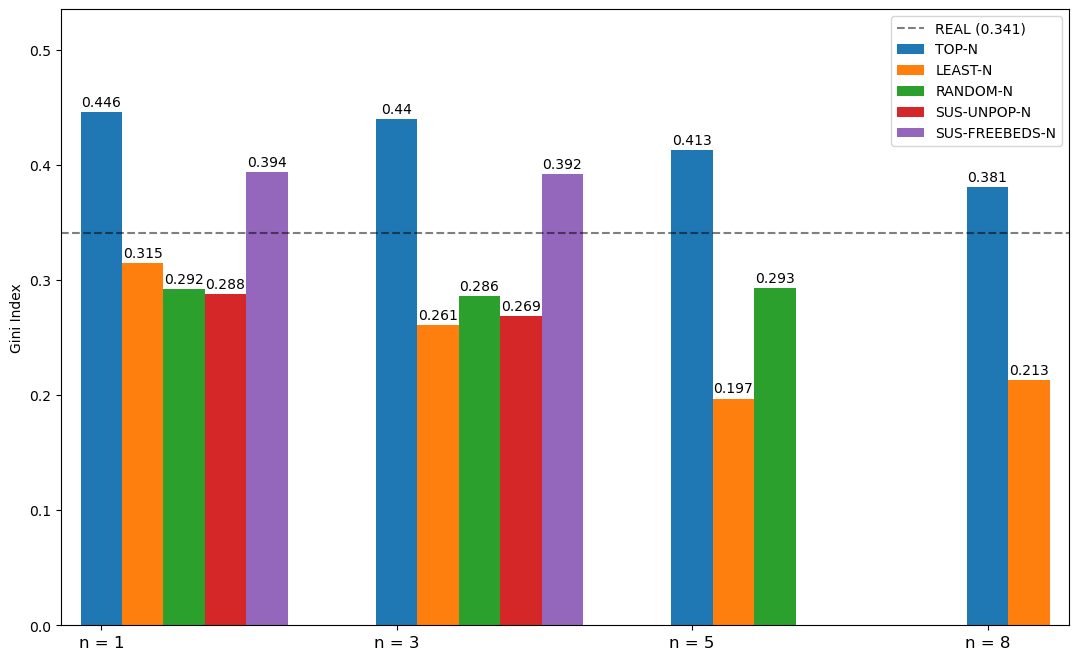

In [7]:
# GINI ARRIVALS

labels = ['n = 1', 'n = 3', 'n = 5', 'n = 8']

topNArrivals = np.round(giniTopNDf["Arrivals"][[0, 2, 4, 7]], 3)
bottomNArrivals = np.round(giniBottomNDf["Arrivals"][[0, 2, 4, 7]], 3)
randomNArrivals = np.round(np.concatenate((giniRandomNDf["Arrivals"][[0, 2, 4]], np.array([np.NaN])), axis=None), 3) # giniRandomNDf["Arrivals"]
sustainableNArrivals = np.round(np.concatenate((giniSustainableNDf["Arrivals"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)   #giniSustainableNDf["Arrivals"].
capacityNArrivals = np.round(np.concatenate((giniCapacityNDf["Arrivals"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)
realityArrivals = np.repeat(0.341, 4)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, topNArrivals, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottomNArrivals, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, randomNArrivals, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sustainableNArrivals, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, capacityNArrivals, width/5, label='SUS-FREEBEDS-N')

hmm = ax.axhline(0.341, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.341)')

ax.set_ylabel('Gini Index')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
ax.bar_label(rects5, padding=2)


plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.2)


fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/sim/gini_index_arrivals.png', bbox_inches='tight')

#### Gini Present to Population

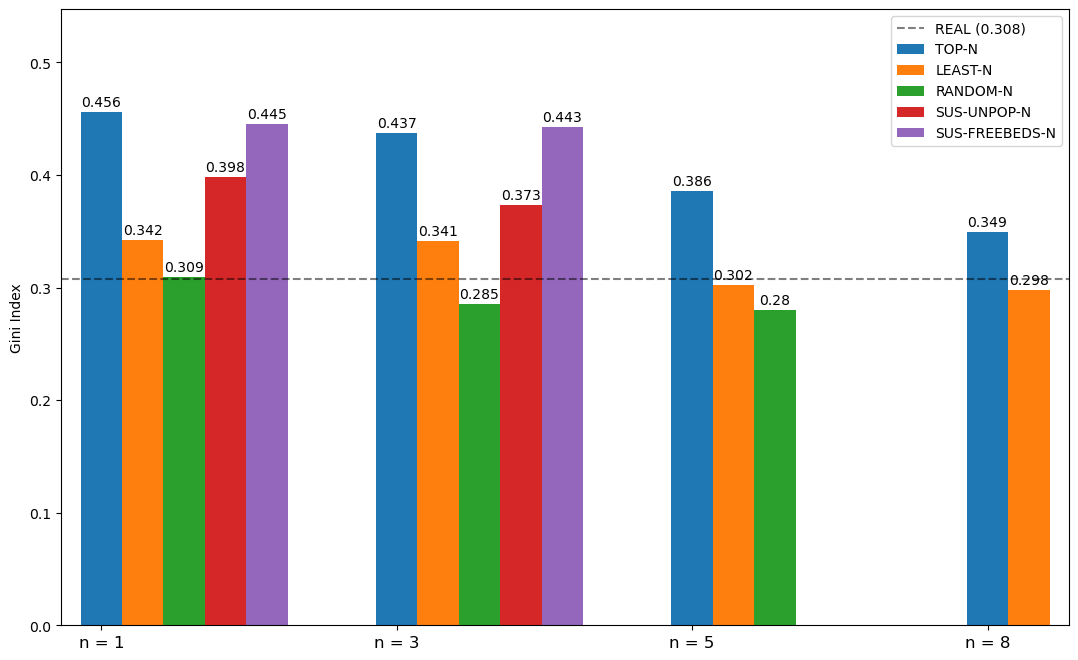

<Figure size 640x480 with 0 Axes>

In [8]:
# GINI PRES to POP

labels = ['n = 1', 'n = 3', 'n = 5', 'n = 8']

topNArrivals = np.round(giniTopNDf["AvgPresentPop"][[0, 2, 4, 7]], 3)
bottomNArrivals = np.round(giniBottomNDf["AvgPresentPop"][[0, 2, 4, 7]], 3)
randomNArrivals = np.round(np.concatenate((giniRandomNDf["AvgPresentPop"][[0, 2, 4]], np.array([np.NaN])), axis=None), 3) 
sustainableNArrivals = np.round(np.concatenate((giniSustainableNDf["AvgPresentPop"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)
capacityNArrivals = np.round(np.concatenate((giniCapacityNDf["AvgPresentPop"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)
realityArrivals = np.repeat(0.341, 4)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, topNArrivals, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottomNArrivals, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, randomNArrivals, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sustainableNArrivals, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, capacityNArrivals, width/5, label='SUS-FREEBEDS-N')


hmm = ax.axhline(0.308, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.308)')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gini Index')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
ax.bar_label(rects5, padding=2)

plt.xticks(fontsize= 12)

plt.margins(0.02, 0.2)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('../img/sim/gini_index_pres_to_pop.png', bbox_inches='tight')

#### Gini Present to Beds

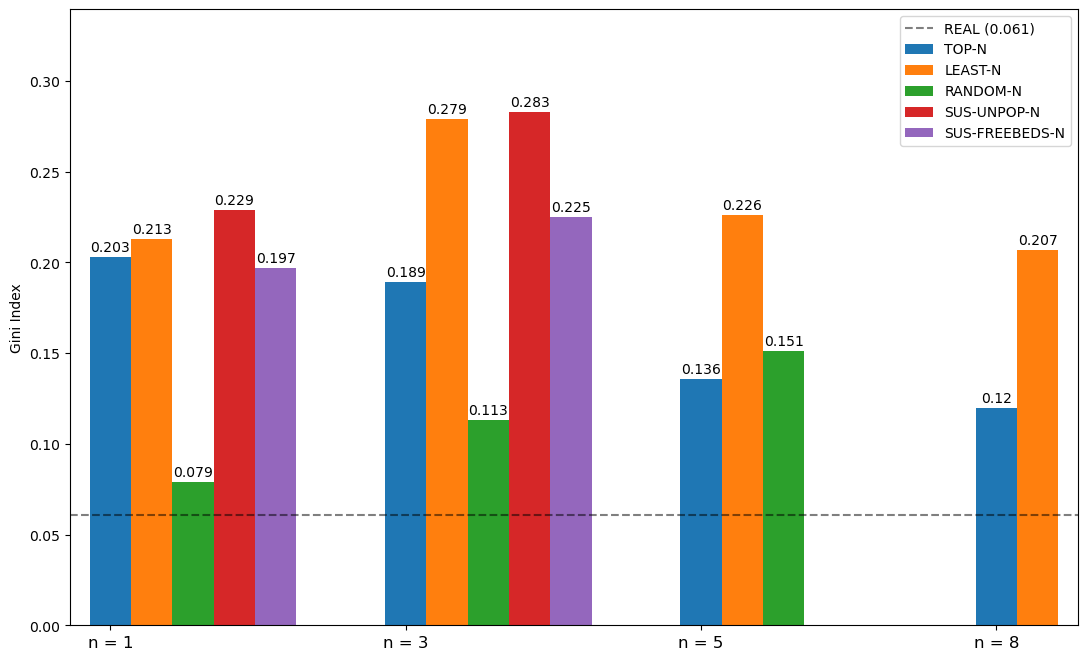

<Figure size 640x480 with 0 Axes>

In [9]:
# GINI PRES to BEDS

labels = ['n = 1', 'n = 3', 'n = 5', 'n = 8']

topNArrivals = np.round(giniTopNDf["AvgPresentBeds"][[0, 2, 4, 7]], 3)
bottomNArrivals = np.round(giniBottomNDf["AvgPresentBeds"][[0, 2, 4, 7]], 3)
randomNArrivals = np.round(np.concatenate((giniRandomNDf["AvgPresentBeds"][[0, 2, 4]], np.array([np.NaN])), axis=None), 3) 
sustainableNArrivals = np.round(np.concatenate((giniSustainableNDf["AvgPresentBeds"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)   
capacityNArrivals = np.round(np.concatenate((giniCapacityNDf["AvgPresentBeds"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3) 
realityArrivals = np.repeat(0.341, 4)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, topNArrivals, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottomNArrivals, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, randomNArrivals, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sustainableNArrivals, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, capacityNArrivals, width/5, label='SUS-FREEBEDS-N')

hmm = ax.axhline(0.061, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.061)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gini Index')
# ax.set_title('(c) Avg. Presence To Number of Beds Ratio')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
ax.bar_label(rects5, padding=2)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.2)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('../img/sim/gini_index_pres_to_beds.png', bbox_inches='tight')

#### Popularity - avg. consumed item popularity

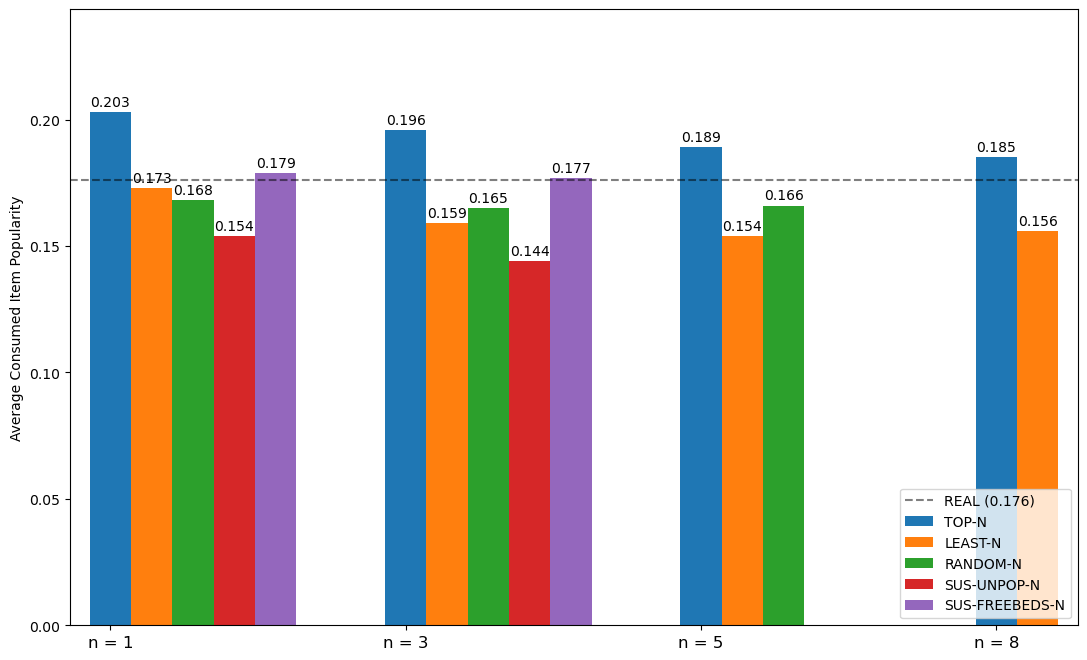

In [10]:
# POPULARITY

labels = ['n = 1', 'n = 3', 'n = 5', 'n = 8']

popTopNDf = pd.read_csv('../data/topNPopularity.csv')
popBottomNDf = pd.read_csv('../data/bottomNPopularity.csv')
popRandomNDf = pd.read_csv('../data/randomNPopularity.csv')
popSustainableNDf = pd.read_csv('../data/sustainableNPopularity.csv')
popCapacityNDf = pd.read_csv('../data/capacityNPopularity.csv')

top = np.round(popTopNDf["0"][[0, 2, 4, 7]], 3)
bottom = np.round(popBottomNDf["0"][[0, 2, 4, 7]], 3)
random = np.round(np.concatenate((popRandomNDf["0"][[0, 2, 4]], np.array([np.NaN])), axis=None), 3)
sus = np.round(np.concatenate((popSustainableNDf["0"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)
cap = np.round(np.concatenate((popCapacityNDf["0"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, top, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottom, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, random, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sus, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, cap, width/5, label='SUS-FREEBEDS-N')

hmm = ax.axhline(0.176, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.176)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Consumed Item Popularity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
ax.bar_label(rects5, padding=2)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.2)


fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/sim/avg_pop.png', bbox_inches='tight')

#### Conversion rate

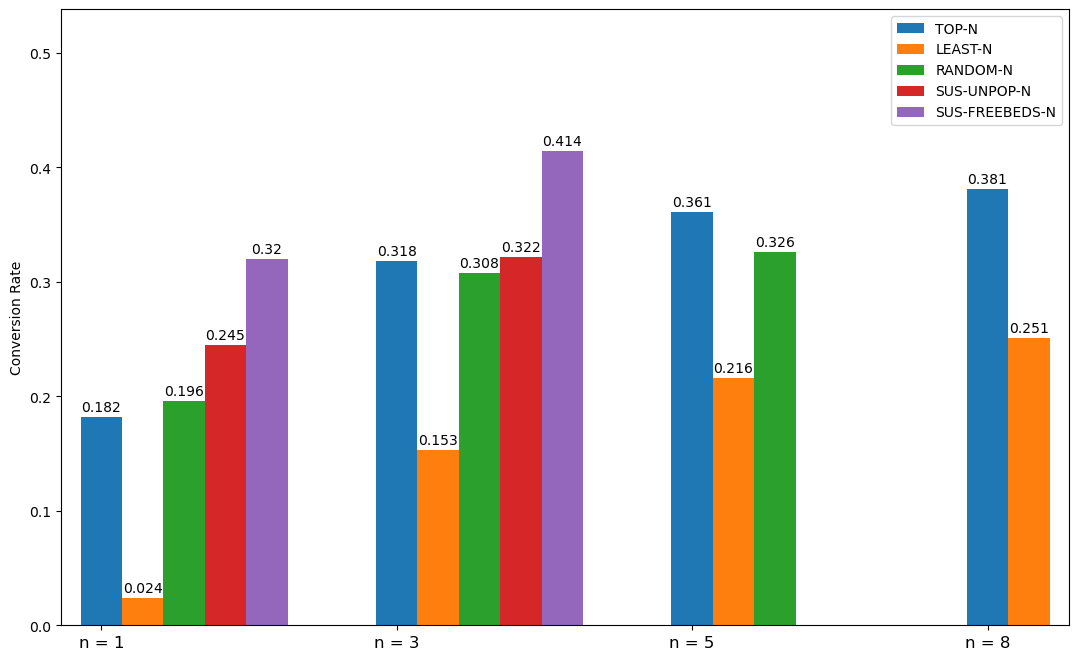

In [11]:
labels = ['n = 1', 'n = 3', 'n = 5', 'n = 8']

accTopNDf = pd.read_csv('../data/topNTableAcc.csv')
accBottomNDf = pd.read_csv('../data/bottomNTableAcc.csv')
accRandomNDf = pd.read_csv('../data/randomNTableAcc.csv')
accSustainableNDf = pd.read_csv('../data/sustainableNTableAcc.csv')
accCapacityNDf = pd.read_csv('../data/capacityNTableAcc.csv')

top = np.round(accTopNDf["Changed"][[0, 2, 4, 7]], 3)
bottom = np.round(accBottomNDf["Changed"][[0, 2, 4, 7]], 3)
random = np.round(np.concatenate((accRandomNDf["Changed"][[0, 2, 4]], np.array([np.NaN])), axis=None), 3)
sus = np.round(np.concatenate((accSustainableNDf["Ratio"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)
cap = np.round(np.concatenate((accCapacityNDf["Changed"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, top, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottom, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, random, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sus, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, cap, width/5, label='SUS-FREEBEDS-N')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Conversion Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
ax.bar_label(rects5, padding=2)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.3)
fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/sim/conv_rate.png', bbox_inches='tight')

#### Recommendation acceptance 
How frequently are the items promoted by the considered marketing strategies consumed?

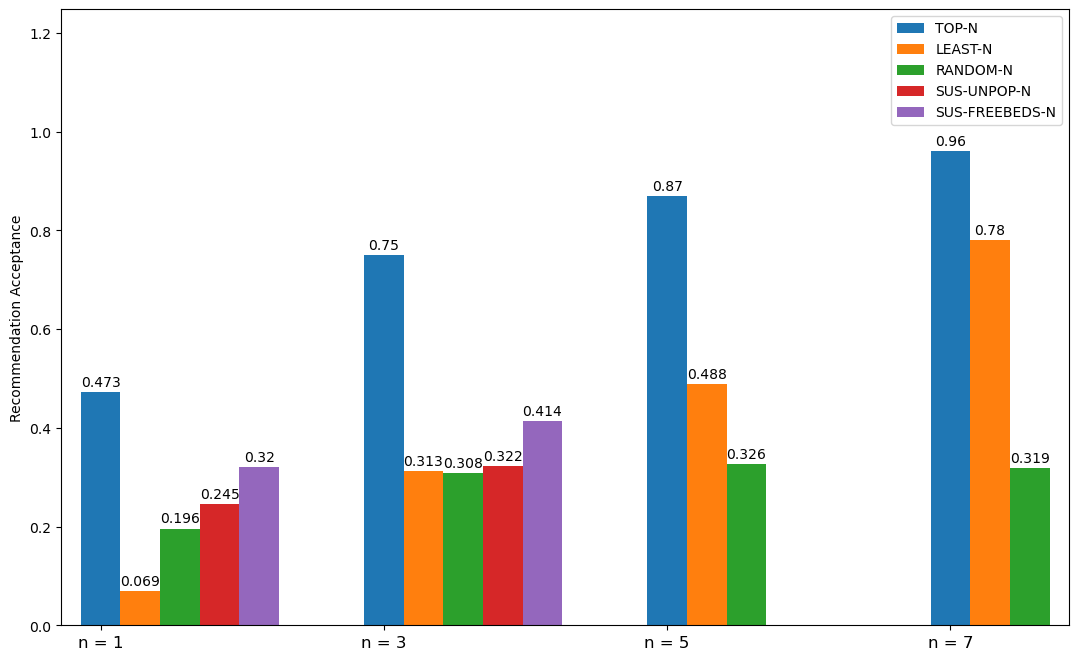

In [12]:
# REC ACC - CHOICE CHANGED

labels = ['n = 1', 'n = 3', 'n = 5', 'n = 7']

accTopNDf = pd.read_csv('../data/topNTableAcc.csv')
accBottomNDf = pd.read_csv('../data/bottomNTableAcc.csv')
accRandomNDf = pd.read_csv('../data/randomNTableAcc.csv')
accSustainableNDf = pd.read_csv('../data/sustainableNTableAcc.csv')
accCapacityNDf = pd.read_csv('../data/capacityNTableAcc.csv')

top = np.round(accTopNDf["Consumed"][[0, 2, 4, 6]], 3)
bottom = np.round(accBottomNDf["Consumed"][[0, 2, 4, 6]], 3)
random = np.round(accRandomNDf["Consumed"][[0, 2, 4, 6]], 3)
sus = np.round(np.concatenate((accSustainableNDf["Ratio"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)
cap = np.round(np.concatenate((accCapacityNDf["Changed"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, top, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottom, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, random, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sus, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, cap, width/5, label='SUS-FREEBEDS-N')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Recommendation Acceptance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
ax.bar_label(rects5, padding=2)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.3)


fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/sim/rec_acc.png', bbox_inches='tight')

## Experiments for different conversion rates

Rerun experiments for 2019 | ALL_COUNTRIES | CONV_RATE = 25% | 50% | 75% | 100%

In [ ]:
conv_rates = [0, 12.5, 25, 50]

In [ ]:
cResults = {}

N = 3

for cr in conv_rates:
    
    cResults[cr] = {}
    
    for i in range(1, 6):
        
        cResults[cr][i] = on_run_simulation_btn_click(2019, SIM_TYPE_TOPN, N, cr, 100, [], ALL_COUNTRIES, 1.2)
        

In [ ]:
bottomNR = cResults

In [ ]:
topNR = cResults

In [ ]:
capacityNR = cResults

In [ ]:
sustainableNR = cResults

In [ ]:
randomNR = cResults

In [ ]:
cTable = []

for cr in conv_rates:

    arrivalsSum = 0
    avgPresentSum = 0
    avgPresentPopSum = 0
    avgPresentBedSum = 0
    
    for i in range(1, 6):
        
            arrivalsSimulated = capacityNR[cr][i][0]
        
            districts = gp.read_file('../data/geo_district_df.shp')

            yearlyDf = arrivalsSimulated[arrivalsSimulated['Year'] == 2019]

            yearlyDf = yearlyDf.groupby(['district_c']).sum()

            yearlyDf = districts.merge(yearlyDf, on='district_c',
                                     how="inner", suffixes=('', '_y'))
            
            if cr == 0:
                yearlyDf["sim_present"] = yearlyDf["Present"]

            yearlyDf["AvgPresentSim"] = yearlyDf["sim_present"] / 365
            yearlyDf["AvgPresentToBedsSim"] = yearlyDf["AvgPresentSim"] / yearlyDf["beds"]
            yearlyDf["AvgPresentToPopSim"] = yearlyDf["AvgPresentSim"] / yearlyDf["population"]


            yearlyDf["AvgPresent"] = yearlyDf["Present"] / 365
            yearlyDf["AvgPresentToBeds"] = yearlyDf["AvgPresent"] / yearlyDf["beds"]
            yearlyDf["AvgPresentToPop"] = yearlyDf["AvgPresent"] / yearlyDf["population"]
            
            arrivals = gini_coefficient(np.array(yearlyDf['Arrivals_sim'].values.tolist()))
            avgPresent = gini_coefficient(np.array(yearlyDf['AvgPresentSim'].values.tolist()))
            avgPresentPop = gini_coefficient(np.array(yearlyDf['AvgPresentToPopSim'].values.tolist()))
            avgPresentBeds = gini_coefficient(np.array(yearlyDf['AvgPresentToBedsSim'].values.tolist()))
            
    giniArrivals = arrivalsSum / 5
    giniAvgPresent = avgPresentSum / 5
    giniAvgPresentPop = avgPresentPopSum / 5
    giniAvgPresentBed = avgPresentBedSum / 5
    
    cTable.append([arrivals, avgPresent, avgPresentPop, avgPresentBeds])

In [ ]:
sustainableNTableCR = pd.DataFrame(cTable, index = conv_rates, columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
sustainableNTableCR.to_csv('../data/CR/sustainableN.csv')

In [ ]:
sustainableNTableCR

In [ ]:
capacityNTableCR = pd.DataFrame(cTable, index = conv_rates, columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
capacityNTableCR.to_csv('../data/CR/capacityN.csv')

In [ ]:
capacityNTableCR

In [ ]:
randomNTableCR = pd.DataFrame(cTable, index = conv_rates, columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
randomNTableCR.to_csv('../data/CR/randomN.csv')

In [ ]:
randomNTableCR

In [ ]:
topNTableCR = pd.DataFrame(cTable, index = conv_rates, columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
topNTableCR.to_csv('../data/CR/topN.csv')

In [ ]:
topNTableCR

In [ ]:
bottomNTableCR = pd.DataFrame(cTable, index = conv_rates, columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
bottomNTableCR.to_csv('../data/CR/bottomNTableCR.csv')

In [ ]:
bottomNTableCR

In [ ]:
topNDf = pd.read_csv('../data/SR/topN.csv')
bottomNDf = pd.read_csv('../data/SR/bottomN.csv')
randomNDf = pd.read_csv('../data/SR/randomN.csv')
sustainableNDf = pd.read_csv('../data/SR/sustainableN.csv')
capacityNDf = pd.read_csv('../data/SR/capacityN.csv')

x = [0, 12.5, 25, 50]

fig, ax = plt.subplots(figsize=(13, 8))

ax.plot(x, topNTableCR["Arrivals"], label='TOP-N')
ax.plot(x, bottomNTableCR["Arrivals"], label='LEAST-N')
ax.plot(x, randomNTableCR["Arrivals"], label='RANDOM-N')
ax.plot(x, sustainableNTableCR["Arrivals"], label='SUS-UNPOP-N')
ax.plot(x, capacityNTableCR["Arrivals"], label='SUS-FREEBEDS-N')

ax.legend(loc='upper left')

plt.xticks(x, x)
plt.xlabel('Conversion Rate (%)')
plt.ylabel('Gini index')

fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/rc/gini_index_arrivals_line.png', bbox_inches='tight')

In [ ]:
labels = ['CR = 0%', 'CR = 12.5%', 'CR = 25%', 'CR = 50%']

top = np.round(topNTableCR["Arrivals"], 2)
bottom = np.round(bottomNTableCR["Arrivals"], 2)
random = np.round(randomNTableCR["Arrivals"], 2)
sus = np.round(sustainableNTableCR["Arrivals"], 2)
cap = np.round(capacityNTableCR["Arrivals"], 2)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
# rects5 = ax.bar(x - 2*width/4, realityArrivals, width/4, label='REAL', color='#9566bd')
rects1 = ax.bar(x, top, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottom, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, random, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sus, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, cap, width/5, label='SUS-FREEBEDS-N')

hmm = ax.axhline(0.341, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.341)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gini Index')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

ax.bar_label(rects1, padding=2, rotation=45)
ax.bar_label(rects2, padding=2, rotation=45)
ax.bar_label(rects3, padding=2, rotation=45)
ax.bar_label(rects4, padding=2, rotation=45)
ax.bar_label(rects5, padding=2, rotation=45)

plt.xticks(fontsize= 12)


plt.margins(0.02, 0.3)

fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/rc/gini_index_arrivals.png', bbox_inches='tight')

In [ ]:
labels = ['CR = 0%', 'CR = 12.5%', 'CR = 25%', 'CR = 50%']

top = np.round(topNTableCR["AvgPresentPop"], 2)
bottom = np.round(bottomNTableCR["AvgPresentPop"], 2)
random = np.round(randomNTableCR["AvgPresentPop"], 2)
sus = np.round(sustainableNTableCR["AvgPresentPop"], 2)
cap = np.round(capacityNTableCR["AvgPresentPop"], 2)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, top, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottom, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, random, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sus, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, cap, width/5, label='SUS-FREEBEDS-N')

hmm = ax.axhline(0.31, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.308)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gini Index')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

ax.bar_label(rects1, padding=2, rotation=45)
ax.bar_label(rects2, padding=2, rotation=45)
ax.bar_label(rects3, padding=2, rotation=45)
ax.bar_label(rects4, padding=2, rotation=45)
ax.bar_label(rects5, padding=2, rotation=45)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.3)

fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/rc/gini_index_avg_pres_pop.png', bbox_inches='tight')

In [ ]:
labels = ['CR = 0%', 'CR = 12.5%', 'CR = 25%', 'CR = 50%']

top = np.round(topNTableCR["AvgPresentBeds"], 2)
bottom = np.round(bottomNTableCR["AvgPresentBeds"], 2)
random = np.round(randomNTableCR["AvgPresentBeds"], 2)
sus = np.round(sustainableNTableCR["AvgPresentBeds"], 2)
cap = np.round(capacityNTableCR["AvgPresentBeds"], 2)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, top, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottom, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, random, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sus, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, cap, width/5, label='SUS-FREEBEDS-N')

hmm = ax.axhline(0.061, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.061)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gini Index')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

ax.bar_label(rects1, padding=2, rotation=45)
ax.bar_label(rects2, padding=2, rotation=45)
ax.bar_label(rects3, padding=2, rotation=45)
ax.bar_label(rects4, padding=2, rotation=45)
ax.bar_label(rects5, padding=2, rotation=45)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.3)

fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/rc/gini_index_avg_pres_beds.png', bbox_inches='tight')

### Popularity

In [ ]:
pTable = []

for cr in conv_rates:
    
    sumArrivals = 0
    
    for i in range(1, 6):
        
            arrivalsSimulated = sustainableNR[cr][i][0]

            yearlyDf = arrivalsSimulated[arrivalsSimulated['Year'] == 2019]

            yearlyDf = yearlyDf.groupby(['district_c']).sum()
            
            yearlyDf['Popularity'] = yearlyDf['Arrivals'] / totalArrivals2019
            
            sumArrivals = sumArrivals + (yearlyDf['Arrivals_sim']*yearlyDf['Popularity']).sum()

    sumArrivals = sumArrivals / (5*totalArrivals2019)
    
    pTable.append(sumArrivals)

In [ ]:
bottomNTablePopularity = pd.DataFrame(pTable, index = conv_rates)

In [ ]:
bottomNTablePopularity.to_csv('../data/CR/bottomNPopularity.csv')

In [ ]:
topNTablePopularity = pd.DataFrame(pTable, index = conv_rates)

In [ ]:
topNTablePopularity.to_csv('../data/CR/topNPopularity.csv')

In [ ]:
capacityNTablePopularity = pd.DataFrame(pTable, index = conv_rates)

In [ ]:
capacityNTablePopularity.to_csv('../data/CR/capacityNPopularity.csv')

In [ ]:
sustainableNTablePopularity = pd.DataFrame(pTable, index = conv_rates)

In [ ]:
sustainableNTablePopularity.to_csv('../data/CR/sustainableNPopularity.csv')

In [ ]:
randomNTablePopularity = pd.DataFrame(pTable, index = conv_rates)

In [ ]:
randomNTablePopularity.to_csv('../data/CR/randomNPopularity.csv')

In [ ]:
labels = ['CR = 0%', 'CR = 12.5%', 'CR = 25%', 'CR = 50%']

popTopNDf = pd.read_csv('../data/CR/topNPopularity.csv')
popBottomNDf = pd.read_csv('../data/CR/bottomNPopularity.csv')
popRandomNDf = pd.read_csv('../data/CR/randomNPopularity.csv')
popSustainableNDf = pd.read_csv('../data/CR/sustainableNPopularity.csv')
popCapacityNDf = pd.read_csv('../data/CR/capacityNPopularity.csv')

top = np.round(popTopNDf["0"], 2)
bottom = np.round(popBottomNDf["0"], 2)
random = np.round(popRandomNDf["0"], 2)
sus = np.round(popSustainableNDf["0"], 2)
cap = np.round(popCapacityNDf["0"], 2)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, top, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottom, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, random, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sus, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, cap, width/5, label='SUS-FREEBEDS-N')

hmm = ax.axhline(0.18, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.176)')

ax.set_ylabel('Average Consumed Item Popularity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

ax.bar_label(rects1, padding=2, rotation=45)
ax.bar_label(rects2, padding=2, rotation=45)
ax.bar_label(rects3, padding=2, rotation=45)
ax.bar_label(rects4, padding=2, rotation=45)
ax.bar_label(rects5, padding=2, rotation=45)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.2)



fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/rc/avg_consumed_item_pop.png', bbox_inches='tight')

In [ ]:
accTable = []

for cr in conv_rates:

    changedOpinionSum = 0
    consumedFromAdvertisementSum = 0
    
    for i in range(1, 6):
        
        changedOpinionCount = capacityNR[cr][i][1]
        consumedFromAdvertisementCount = capacityNR[cr][i][2]
            
        changedOpinionSum = changedOpinionSum + changedOpinionCount 
        consumedFromAdvertisementSum = consumedFromAdvertisementSum + consumedFromAdvertisementCount

 
    changedRatio =changedOpinionSum / 5 / totalArrivals2019
    consumedRatio =consumedFromAdvertisementSum / 5 / totalArrivals2019
    
    accTable.append([changedRatio, consumedRatio])


In [ ]:
bottomNTableAcc = pd.DataFrame(accTable, index = conv_rates, columns = ["Changed", "Consumed"])

In [ ]:
bottomNTableAcc.to_csv('../data/CR/bottomNTableAcc.csv')

In [ ]:
topNTableAcc = pd.DataFrame(accTable, index = conv_rates, columns = ["Changed", "Consumed"])

In [ ]:
topNTableAcc.to_csv('../data/CR/topNTableAcc.csv')

In [ ]:
randomNTableAcc = pd.DataFrame(accTable, index = conv_rates, columns = ["Changed", "Consumed"])

In [ ]:
randomNTableAcc.to_csv('../data/CR/randomNTableAcc.csv')

In [ ]:
sustainableNTableAcc = pd.DataFrame(accTable, index = conv_rates, columns = ["Changed", "Consumed"])

In [ ]:
sustainableNTableAcc.to_csv('../data/CR/sustainableNTableAcc.csv')

In [ ]:
capacityNTableAcc = pd.DataFrame(accTable, index = conv_rates, columns = ["Changed", "Consumed"])

In [ ]:
capacityNTableAcc.to_csv('../data/CR/capacityNTableAcc.csv')

In [ ]:
labels = ['CR = 0%', 'CR = 12.5%', 'CR = 25%', 'CR = 50%']

accTopNDf = pd.read_csv('../data/CR/topNTableAcc.csv')
accBottomNDf = pd.read_csv('../data/CR/bottomNTableAcc.csv')
accRandomNDf = pd.read_csv('../data/CR/randomNTableAcc.csv')
accSustainableNDf = pd.read_csv('../data/CR/sustainableNTableAcc.csv')
accCapacityNDf = pd.read_csv('../data/CR/capacityNTableAcc.csv')

top = np.round(accTopNDf["Changed"], 3)
bottom = np.round(accBottomNDf["Changed"], 3)
random = np.round(accRandomNDf["Changed"], 3)
sus = np.round(accSustainableNDf["Changed"], 3)
cap = np.round(accCapacityNDf["Changed"], 3)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, top, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottom, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, random, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sus, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, cap, width/5, label='SUS-FREEBEDS-N')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Conversion Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

ax.bar_label(rects1, padding=2, rotation=45)
ax.bar_label(rects2, padding=2, rotation=45)
ax.bar_label(rects3, padding=2, rotation=45)
ax.bar_label(rects4, padding=2, rotation=45)
ax.bar_label(rects5, padding=2, rotation=45)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.3)

fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/rc/conv_rate.png', bbox_inches='tight')

In [ ]:
labels = ['CR = 0%', 'CR = 12.5%', 'CR = 25%', 'CR = 50%']

accTopNDf = pd.read_csv('../data/CR/topNTableAcc.csv')
accBottomNDf = pd.read_csv('../data/CR/bottomNTableAcc.csv')
accRandomNDf = pd.read_csv('../data/CR/randomNTableAcc.csv')
accSustainableNDf = pd.read_csv('../data/CR/sustainableNTableAcc.csv')
accCapacityNDf = pd.read_csv('../data/CR/capacityNTableAcc.csv')

top = np.round(accTopNDf["Consumed"], 3)
bottom = np.round(accBottomNDf["Consumed"], 3)
random = np.round(accRandomNDf["Changed"], 3)
sus = np.round(accSustainableNDf["Changed"], 3)
cap = np.round(accCapacityNDf["Changed"], 3)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = ax.bar(x, top, width/5, label='TOP-N')
rects2 = ax.bar(x + width/5, bottom, width/5, label='LEAST-N')
rects3 = ax.bar(x + width/5*2, random, width/5, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/5, sus, width/5, label='SUS-UNPOP-N')
rects5 = ax.bar(x + 4*width/5, cap, width/5, label='SUS-FREEBEDS-N')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Recommendation Acceptance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

ax.bar_label(rects1, padding=2, rotation=45)
ax.bar_label(rects2, padding=2, rotation=45)
ax.bar_label(rects3, padding=2, rotation=45)
ax.bar_label(rects4, padding=2, rotation=45)
ax.bar_label(rects5, padding=2, rotation=45)

plt.xticks(fontsize= 12)

plt.margins(0.02, 0.3)

fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/rc/rec_acc.png', bbox_inches='tight')

#### Seen rate experiments

In [ ]:
seen_rates = [0, 20, 40, 60, 80, 100]

In [ ]:
sResults = {}

N = 3

for sr in seen_rates:
    
    sResults[sr] = {}
    
    for i in range(1, 6):
        
        sResults[sr][i] = run_random(2019, N, -1, sr, ALL_COUNTRIES, 1.2)
        

In [ ]:
sBottomN = sResults

In [ ]:
sTopN = sResults

In [ ]:
sSustainableN = sResults

In [ ]:
sCapacityN = sResults

In [ ]:
sRandomN = sResults

In [ ]:
sTable = []

for sr in seen_rates:

    arrivalsSum = 0
    avgPresentSum = 0
    avgPresentPopSum = 0
    avgPresentBedSum = 0
    
    for i in range(1, 6):
        
            arrivalsSimulated = sSustainableN[sr][i][0]
        
            districts = gp.read_file('../data/geo_district_df.shp')

            yearlyDf = arrivalsSimulated[arrivalsSimulated['Year'] == 2019]

            yearlyDf = yearlyDf.groupby(['district_c']).sum()

            yearlyDf = districts.merge(yearlyDf, on='district_c',
                                     how="inner", suffixes=('', '_y'))
            
            if(sr == 0):
                yearlyDf["sim_present"] = yearlyDf["Present"]
                

            yearlyDf["AvgPresentSim"] = yearlyDf["sim_present"] / 365
            yearlyDf["AvgPresentToBedsSim"] = yearlyDf["AvgPresentSim"] / yearlyDf["beds"]
            yearlyDf["AvgPresentToPopSim"] = yearlyDf["AvgPresentSim"] / yearlyDf["population"]


            yearlyDf["AvgPresent"] = yearlyDf["Present"] / 365
            yearlyDf["AvgPresentToBeds"] = yearlyDf["AvgPresent"] / yearlyDf["beds"]
            yearlyDf["AvgPresentToPop"] = yearlyDf["AvgPresent"] / yearlyDf["population"]

            # #st.write(np.array(yearlyDf['avgPop'].values.tolist()))
            
            arrivals = gini_coefficient(np.array(yearlyDf['Arrivals_sim'].values.tolist()))
            avgPresent = gini_coefficient(np.array(yearlyDf['AvgPresentSim'].values.tolist()))
            avgPresentPop = gini_coefficient(np.array(yearlyDf['AvgPresentToPopSim'].values.tolist()))
            avgPresentBeds = gini_coefficient(np.array(yearlyDf['AvgPresentToBedsSim'].values.tolist()))
            
    giniArrivals = arrivalsSum / 5
    giniAvgPresent = avgPresentSum / 5
    giniAvgPresentPop = avgPresentPopSum / 5
    giniAvgPresentBed = avgPresentBedSum / 5
    
    sTable.append([arrivals, avgPresent, avgPresentPop, avgPresentBeds])
    
            
print(sTable)

In [ ]:
bottomNTableSR = pd.DataFrame(sTable, index = seen_rates, columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
bottomNTableSR.to_csv('../data/SR/bottomN.csv')

In [ ]:
bottomNTableSR

In [ ]:
topNTableSR = pd.DataFrame(sTable, index = seen_rates, columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
topNTableSR.to_csv('../data/SR/topN.csv')

In [ ]:
topNTableSR

In [ ]:
randomNTableSR = pd.DataFrame(sTable, index = seen_rates, columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
randomNTableSR.to_csv('../data/SR/randomN.csv')

In [ ]:
randomNTableSR

In [ ]:
capacityNTableSR = pd.DataFrame(sTable, index = seen_rates, columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
capacityNTableSR.to_csv('../data/SR/capacityN.csv')

In [ ]:
capacityNTableSR

In [ ]:
sustainableNTableSR = pd.DataFrame(sTable, index = seen_rates, columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [ ]:
sustainableNTableSR.to_csv('../data/SR/sustainableN.csv')

In [ ]:
sustainableNTableSR

In [ ]:
topNDf = pd.read_csv('../data/SR/topN.csv')
bottomNDf = pd.read_csv('../data/SR/bottomN.csv')
randomNDf = pd.read_csv('../data/SR/randomN.csv')
sustainableNDf = pd.read_csv('../data/SR/sustainableN.csv')
capacityNDf = pd.read_csv('../data/SR/capacityN.csv')

realityGini = np.repeat(0.341, 6) # to change

x = seen_rates

fig, ax = plt.subplots(figsize=(13, 8))

ax.plot(x, topNDf["Arrivals"], label='TOP-N')
ax.plot(x, bottomNDf["Arrivals"], label='LEAST-N')
ax.plot(x, randomNDf["Arrivals"], label='RANDOM-N')
ax.plot(x, sustainableNDf["Arrivals"], label='SUS-UNPOP-N')
ax.plot(x, capacityNDf["Arrivals"], label='SUS-FREEBEDS-N')

ax.legend(loc='upper left')

plt.xlabel('Seen Rate (%)')
plt.ylabel('Gini index')

fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/sr/gini_index_arrivals.png', bbox_inches='tight')

In [ ]:
topNDf = pd.read_csv('../data/SR/topN.csv')
bottomNDf = pd.read_csv('../data/SR/bottomN.csv')
randomNDf = pd.read_csv('../data/SR/randomN.csv')
sustainableNDf = pd.read_csv('../data/SR/sustainableN.csv')
capacityNDf = pd.read_csv('../data/SR/capacityN.csv')

x = seen_rates

fig, ax = plt.subplots(figsize=(13, 8))

ax.plot(x, topNDf["AvgPresentPop"], label='TOP-N')
ax.plot(x, bottomNDf["AvgPresentPop"], label='LEAST-N')
ax.plot(x, randomNDf["AvgPresentPop"], label='RANDOM-N')
ax.plot(x, sustainableNDf["AvgPresentPop"], label='SUS-UNPOP-N')
ax.plot(x, capacityNDf["AvgPresentPop"], label='SUS-FREEBEDS-N')

ax.legend(loc='upper left')

plt.xlabel('Seen Rate (%)')
plt.ylabel('Gini index')

fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/sr/gini_index_pop.png', bbox_inches='tight')

In [ ]:
topNDf = pd.read_csv('../data/SR/topN.csv')
bottomNDf = pd.read_csv('../data/SR/bottomN.csv')
randomNDf = pd.read_csv('../data/SR/randomN.csv')
sustainableNDf = pd.read_csv('../data/SR/sustainableN.csv')
capacityNDf = pd.read_csv('../data/SR/capacityN.csv')

x = seen_rates

fig, ax = plt.subplots(figsize=(13, 8))

ax.plot(x, topNDf["AvgPresentBeds"], label='TOP-N')
ax.plot(x, bottomNDf["AvgPresentBeds"], label='LEAST-N')
ax.plot(x, randomNDf["AvgPresentBeds"], label='RANDOM-N')
ax.plot(x, sustainableNDf["AvgPresentBeds"], label='SUS-UNPOP-N')
ax.plot(x, capacityNDf["AvgPresentBeds"], label='SUS-FREEBEDS-N')

ax.legend(loc='upper left')

plt.xlabel('Seen Rate (%)')
plt.ylabel('Gini index')

fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/sr/gini_index_beds.png', bbox_inches='tight')

In [ ]:
pTable = []

for sr in seen_rates:
    
    sumArrivals = 0
    
    for i in range(1, 6):
        
            arrivalsSimulated = sTopN[sr][i][0]

            yearlyDf = arrivalsSimulated[arrivalsSimulated['Year'] == 2019]

            yearlyDf = yearlyDf.groupby(['district_c']).sum()
            
            yearlyDf['Popularity'] = yearlyDf['Arrivals'] / totalArrivals2019
            
            sumArrivals = sumArrivals + (yearlyDf['Arrivals_sim']*yearlyDf['Popularity']).sum() 

    sumArrivals = sumArrivals / (5*totalArrivals2019)
    
    pTable.append(sumArrivals)

In [ ]:
bottomNTablePopularityS = pd.DataFrame(pTable, index = seen_rates)

In [ ]:
bottomNTablePopularityS.to_csv("../data/SR/bottomNTablePopularityS.csv")

In [ ]:
topNTablePopularityS = pd.DataFrame(pTable, index = seen_rates)


In [ ]:
topNTablePopularityS.to_csv("../data/SR/topNTablePopularityS.csv")

In [ ]:
randomNTablePopularityS = pd.DataFrame(pTable, index = seen_rates)


In [ ]:
randomNTablePopularityS.to_csv("../data/SR/randomNTablePopularityS.csv")

In [ ]:
sustainableNTablePopularityS = pd.DataFrame(pTable, index = seen_rates)

In [ ]:
sustainableNTablePopularityS.to_csv("../data/SR/sustainableNTablePopularityS.csv")

In [ ]:
capacityNTablePopularityS = pd.DataFrame(pTable, index = seen_rates)

In [ ]:
capacityNTablePopularityS.to_csv("../data/SR/capacityNTablePopularityS.csv")

In [ ]:
topNDf = pd.read_csv('../data/SR/topNTablePopularityS.csv')
bottomNDf = pd.read_csv('../data/SR/bottomNTablePopularityS.csv')
randomNDf = pd.read_csv('../data/SR/randomNTablePopularityS.csv')
sustainableNDf = pd.read_csv('../data/SR/sustainableNTablePopularityS.csv')
capacityNDf = pd.read_csv('../data/SR/capacityNTablePopularityS.csv')

x = seen_rates

fig, ax = plt.subplots(figsize=(13, 8))

ax.plot(x, topNDf["0"], label='TOP-N')
ax.plot(x, bottomNDf["0"], label='LEAST-N', linewidth=2.0)
ax.plot(x, randomNDf["0"], label='RANDOM-N')
ax.plot(x, sustainableNDf["0"], label='SUS-UNPOP-N')
ax.plot(x, capacityNDf["0"], label='SUS-FREEBEDS-N')

ax.legend(loc='upper left')

plt.xlabel('Seen Rate (%)')
plt.ylabel('Average Consumed Item Popularity')


fig1 = plt.gcf()
plt.show()
fig1.savefig('../img/sr/pop.png', bbox_inches='tight')

In [ ]:
accTable = []

for sr in seen_rates:

    changedOpinionSum = 0
    consumedFromAdvertisementSum = 0
    
    for i in range(1, 6):
        
        changedOpinionCount = sCapacityN[sr][i][1]
        consumedFromAdvertisementCount = sCapacityN[sr][i][2]
            
        changedOpinionSum = changedOpinionSum + changedOpinionCount 
        consumedFromAdvertisementSum = consumedFromAdvertisementSum + consumedFromAdvertisementCount

 
    changedRatio =changedOpinionSum / 5 / totalArrivals2019
    consumedRatio =consumedFromAdvertisementSum / 5 / totalArrivals2019
    
    accTable.append([changedRatio, consumedRatio])

In [ ]:
bottomNTableAccS = pd.DataFrame(accTable, index = seen_rates, columns = ["Changed", "Consumed"])

In [ ]:
bottomNTableAccS.to_csv("../data/SR/bottomNTableAccS.csv")

In [ ]:
topNTableAccS = pd.DataFrame(accTable, index = seen_rates, columns = ["Changed", "Consumed"])

In [ ]:
topNTableAccS.to_csv("../data/SR/topNTableAccS.csv")

In [ ]:
randomNTableAccS = pd.DataFrame(accTable, index = seen_rates, columns = ["Changed", "Consumed"])

In [ ]:
randomNTableAccS.to_csv("../data/SR/randomNTableAccS.csv")

In [ ]:
sustainableNTableAccS = pd.DataFrame(accTable, index = seen_rates, columns = ["Changed", "Consumed"])

In [ ]:
sustainableNTableAccS.to_csv("../data/SR/sustainableNTableAccS.csv")

In [ ]:
capacityNTableAccS = pd.DataFrame(accTable, index = seen_rates, columns = ["Changed", "Consumed"])

In [ ]:
capacityNTableAccS.to_csv("../data/SR/capacityNTableAccS.csv")

In [ ]:
topNDf = pd.read_csv('../data/SR/topNTableAccS.csv')
bottomNDf = pd.read_csv('../data/SR/bottomNTableAccS.csv')
randomNDf = pd.read_csv('../data/SR/randomNTableAccS.csv')
sustainableNDf = pd.read_csv('../data/SR/sustainableNTableAccS.csv')
capacityNDf = pd.read_csv('../data/SR/capacityNTableAccS.csv')

x = seen_rates

fig, ax = plt.subplots(figsize=(13, 8))

ax.plot(x, topNDf["Changed"], label='TOP-N')
ax.plot(x, bottomNDf["Changed"], label='LEAST-N')
ax.plot(x, randomNDf["Changed"], label='RANDOM-N')
ax.plot(x, sustainableNDf["Changed"], label='SUS-UNPOP-N')
ax.plot(x, capacityNDf["Changed"], label='SUS-FREEBEDS-N')
ax.legend(loc='upper left')


plt.xlabel('Seen Rate (%)')
plt.ylabel('Conversion rate')


fig1 = plt.gcf()
plt.show()

fig1.savefig('../img/sr/cr.png', bbox_inches='tight')

In [ ]:
topNDf = pd.read_csv('../data/SR/topNTableAccS.csv')
bottomNDf = pd.read_csv('../data/SR/bottomNTableAccS.csv')
randomNDf = pd.read_csv('../data/SR/randomNTableAccS.csv')
sustainableNDf = pd.read_csv('../data/SR/sustainableNTableAccS.csv')
capacityNDf = pd.read_csv('../data/SR/capacityNTableAccS.csv')

x = seen_rates

fig, ax = plt.subplots(figsize=(13, 8))

ax.plot(x, topNDf["Consumed"], label='TOP-N')
ax.plot(x, bottomNDf["Consumed"], label='LEAST-N' )
ax.plot(x, randomNDf["Consumed"], label='RANDOM-N')
ax.plot(x, sustainableNDf["Changed"], label='SUS-UNPOP-N')
ax.plot(x, capacityNDf["Changed"], label='SUS-FREEBEDS-N')

ax.legend(loc='upper left')

plt.xlabel('Seen Rate (%)')
plt.ylabel('Recommendation Acceptance')

fig1 = plt.gcf()
plt.show()Ï
fig1.savefig('../img/sr/ra.png', bbox_inches='tight')